In [1]:
from data_process import data_processing

# Combine all data files into one. Combined data saved at <output_path>
data_path = "./data/"
output_path = "./result/"
data_processing(data_path, 2018, output_path)
data_processing(data_path, 2019, output_path)
data_processing(data_path, 2020, output_path)

/Users/yao/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


csv_path: ['./data/2018/002050.SZ-策略五- E7200-2018_5s.csv', './data/2018/600176.SH-策略五- E600-2018_5s.csv', './data/2018/600436.SH-策略五- E72000-2018_5s.csv', './data/2018/603027.SH-差商策略 E72000-2018_10s.csv', './data/2018/600872.SH-差商策略 E14400-2018_5s.csv', './data/2018/002938.SZ-差商策略 E7200-2018_5s.csv', './data/2018/600298.SH-差商策略 E14400-2018_1s.csv', './data/2018/002384.SZ-策略五- E600-2018_5s.csv', './data/2018/002594.SZ-差商策略(344) E72000-2018_10s.csv', './data/2018/600887.SH-策略五- E7200-2018_10s.csv', './data/2018/002340.SZ-策略五- E3600-2018_5s.csv', './data/2018/601012.SH-差商策略 E72000-2018_5s.csv', './data/2018/600845.SH-策略五- E600-2018_5s.csv', './data/2018/600522.SH-差商策略 E14400-2018_1s.csv', './data/2018/002415.SZ-策略五- E600-2018_5s.csv']
csv_path: ['./data/2019/603027.SH-差商策略 E72000-2019_10s.csv', './data/2019/002340.SZ-策略五- E3600-2019_5s.csv', './data/2019/002415.SZ-策略五- E600-2019_5s.csv', './data/2019/600522.SH-差商策略 E14400-2019_1s.csv', './data/2019/002594.SZ-差商策略(344) E72000-2019_10s.csv'

In [2]:
import pandas as pd
import numpy as np
import os

# load dataset from combined data
columns = [' E30',' E90',' E240',' E600',' E1500',' E3600',' E7200',' E14400',' E72000',' E144000','label_tfm']
data_18 = pd.read_csv(os.path.join(output_path, "2018processed_data.csv"))
data_19 = pd.read_csv(os.path.join(output_path, "2019processed_data.csv"))
data_20 = pd.read_csv(os.path.join(output_path, "2020processed_data.csv"))
features = columns[:-1]

# 2018, 2019 as training dataset; 2020 as test dataset. Use only buy-points.
data_18_buy = data_18.loc[data_18["action_duo"] == 100].reset_index(drop=True)
data_19_buy = data_19.loc[data_19["action_duo"] == 100].reset_index(drop=True)
data_20_buy = data_20.loc[data_20["action_duo"] == 100].reset_index(drop=True)
train = pd.DataFrame()
train = train.append(data_18_buy[columns])
train = train.append(data_19_buy[columns])
test = data_20_buy[columns]

# seperate data and labels
X_train = train[features]
y_train = train[columns[-1]]
X_test = test[features]
y_test = test[columns[-1]]


# normalization
for feature in features:
    X_train[feature] = (X_train[feature]-X_train[feature].mean()) / X_train[feature].std()
    test[feature] = (test[feature] - test[feature].mean()) / test[feature].std()

X_train.head()

/Users/yao/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yao/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,E30,E90,E240,E600,E1500,E3600,E7200,E14400,E72000,E144000
0,-0.262276,-0.310328,-0.258079,0.002855,0.061845,-0.076221,-0.205858,-0.891307,-0.978174,-0.251192
1,-0.262276,-0.310328,-0.331746,-0.391057,-0.341432,-0.239348,-0.291806,-0.463984,0.462447,0.557755
2,-0.262276,-0.310328,-0.314940,-0.339541,-0.320704,-0.256968,-0.281936,-0.406766,-0.080578,0.350900
3,-0.262276,-0.310328,-0.418832,-0.511235,-0.419295,-0.284881,-0.282307,-0.390844,-0.473448,-0.245263
4,-0.262276,-0.310328,-0.286784,-0.268893,-0.226587,-0.157613,-0.175742,-0.307809,0.292799,0.735894


In [29]:
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.datasets import  make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# build XGBoost model
# lower <scale_pos_weight> can result more total selection points
# good <n_estimators> can result higher TP rate
model = XGBClassifier(learning_rate =0.1,
 eta=0.05,
 n_estimators=2000,
 max_depth=5,
 min_child_weight=1,
 subsample=0.7,
 colsample_bytree=0.8,
 reg_lambda=1,
 nthread=4,
 scale_pos_weight=.8,
 seed=27)

# fit the model
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Confusion matrix: {}".format(confusion_matrix(y_test, predictions)))

/Users/yao/.pyenv/versions/3.6.4/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion matrix: [[12 99]
 [ 2 95]]


In [32]:
# save selected trading points to file "selection.csv".
data_buy = data_20_buy.copy()
data_buy['predict_label'] = predictions
data_sell = data_20.loc[data_20["action_duo"] == -100].reset_index(drop=True)
data_sell['predict_label'] = predictions
data_output = pd.DataFrame()
data_output = data_output.append(data_buy)
data_output = data_output.append(data_sell)
data_output = data_output.sort_values(by=[' id', 'time'])
print(data_output)
data_output.to_csv(os.path.join(output_path, "selection.csv"), encoding="utf_8_sig", index=False)

                    time          id   close   volume    amount     E30  \
21   2020-02-06 10:14:40   002050.SZ   21.55   3620.0   77897.0  4569.6   
21   2020-02-13 14:58:45   002050.SZ   22.36      0.0       0.0     0.0   
22   2020-02-14 14:58:30   002050.SZ   21.97      0.0       0.0     0.0   
22   2020-02-20 14:59:10   002050.SZ   21.92      0.0       0.0     0.0   
23   2020-02-21 14:58:40   002050.SZ   21.86      0.0       0.0     0.0   
..                   ...         ...     ...      ...       ...     ...   
103  2020-09-03 13:43:50   603027.SH   43.97   6670.0  293484.8 -2214.9   
104  2020-09-29 14:50:50   603027.SH   36.75   1230.0   45182.9  1166.1   
104  2020-10-23 13:51:50   603027.SH   39.95   1520.0   60772.9 -2227.5   
105  2020-10-28 13:00:50   603027.SH   40.67   1470.0   59809.1   268.3   
105  2020-11-05 10:11:50   603027.SH   38.46    250.0    9619.9   -63.0   

          E90        E240        E600         E1500  ...          卖出价格  \
21   15016.20   35903.032

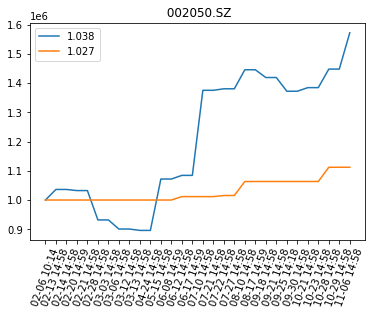

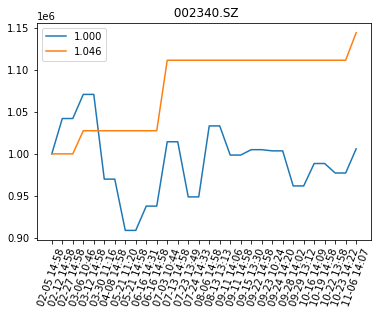

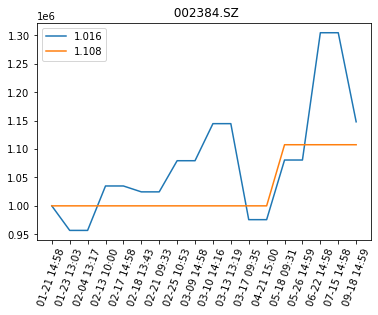

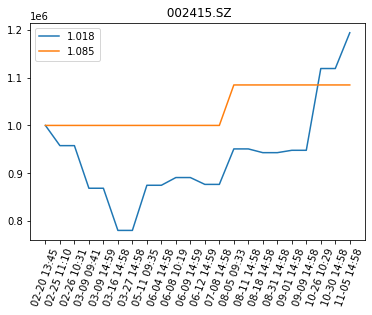

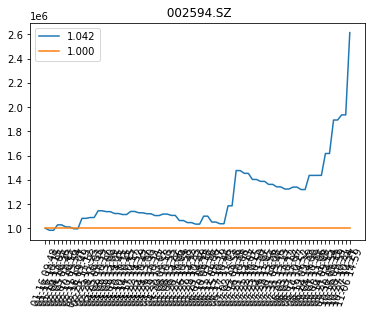

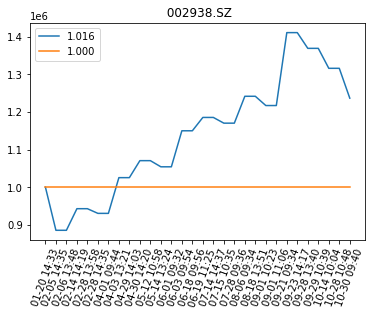

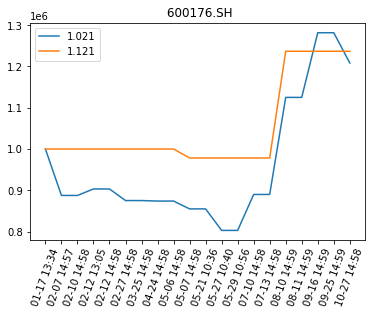

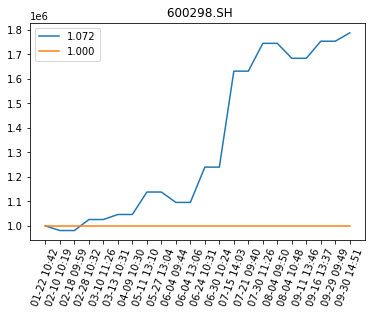

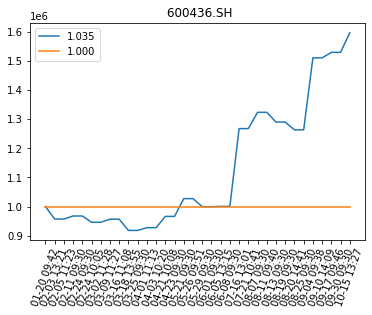

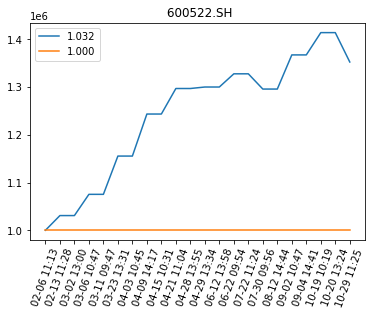

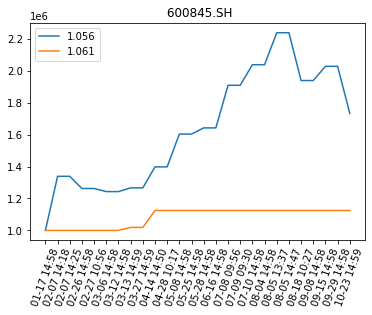

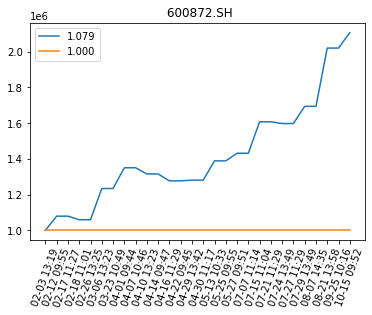

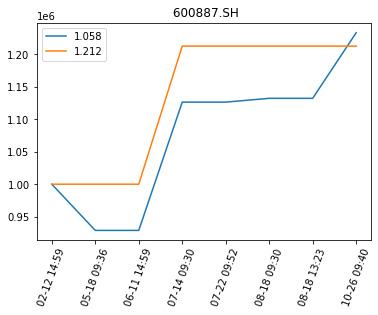

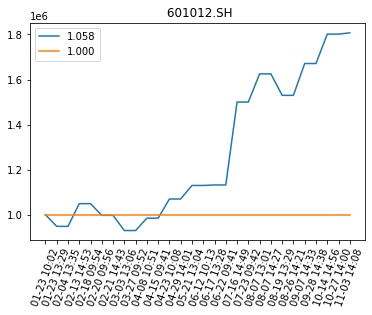

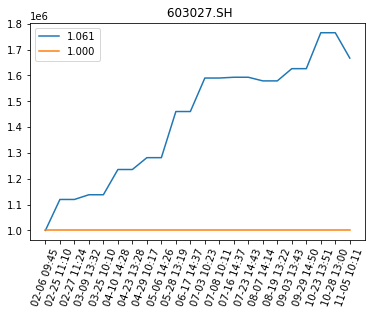

In [61]:
# plot net values
import matplotlib.pyplot as plt

# collect the index of all stocks
stocks = pd.unique(data_output[" id"])
net_origin = 1e6

# for each stock
for stock in stocks:
    # before selection
    one_stock = data_output.loc[data_output[" id"] == stock].reset_index(drop=True)
    time_before_selection = list(one_stock["time"].map(lambda x:x[5:16]))
    net_value_before_selection = list(one_stock["买入价格"] + one_stock["做多剩余资金"])
    # averate gain rate for each trading
    avg_rates_before_selection = \
        (net_value_before_selection[-1]-net_value_before_selection[0])/len(one_stock)*2/net_origin + 1
    
    # after selection
    one_stock_selection = one_stock.loc[one_stock["predict_label"] == 0].reset_index(drop=True)
    time_after_selection = list(one_stock_selection["time"].map(lambda x:x[5:16]))
    time_after_selection = [time_before_selection[0]]+time_after_selection + [time_before_selection[-1]]
    rates = one_stock_selection["单次收益率"].to_numpy() + 1
    rates = np.append([1, 1], rates)
    cum_rates = np.cumprod(rates)
    net_value_after_selection = [net_origin*rate for rate in cum_rates]
    # averate gain rate for each trading
    avg_rates_after_selection = np.mean(rates[rates!=1]) if len(one_stock_selection) else 1
    
    
    plt.figure()
    plt.plot(time_before_selection, net_value_before_selection)
    plt.plot(time_after_selection, net_value_after_selection)
    plt.xticks(rotation=70)
    plt.title(stock)
    plt.legend(["{:.3f}".format(avg_rates_before_selection),"{:.3f}".format(avg_rates_after_selection)])